In [68]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

In [69]:
dealer_data = pd.read_csv('dealer/dealer_data.csv')

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (75,76,77,78,79,105,106,122,123,128,130,132,134,171,172,178,189) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [100]:
# List of relevant columns, including the recovery rate
relevant_columns = [
    'DealCSP', 'PrimaryDealer', 'C2D_Dealer', 'TradeSize', 'C2Ctrades', 'C2Dvolume_PAR', 
    'TradePreCount', 'TradePreVolume', 'TimeToMaturity', 'TimeSinceOffering', 'Default', 
    'TRADE_CHAIN2', 'TRADE_CHAIN3', 'TRADE_CHAIN4', 'TRADE_CHAIN5', 'TRADE_CHAIN6', 'TRADE_CHAIN7', 'TRADE_CHAIN8', 'TRADE_CHAIN9', 'TRADE_CHAIN10',
    'Markup', 'predicted_Primary', 'Rating', 'Commission', 'PostDummy', 'IndustryDefaultRate', 
    'UncertaintyIndex', 'PriceDistance', 'RR_Price'
]

# Limit the DataFrame to the relevant columns
dealer_df_limited = dealer_data[relevant_columns]

# rename DealCSP to CUSIP
dealer_df_limited.rename(columns={'DealCSP': 'CUSIP'}, inplace=True)

# rename RR_price to dealer_RR
dealer_df_limited.rename(columns={'RR_Price': 'dealer_RR'}, inplace=True)

# Display the first few rows of the limited DataFrame
dealer_df_limited.head()

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,CUSIP,PrimaryDealer,C2D_Dealer,TradeSize,C2Ctrades,C2Dvolume_PAR,TradePreCount,TradePreVolume,TimeToMaturity,TimeSinceOffering,...,TRADE_CHAIN10,Markup,predicted_Primary,Rating,Commission,PostDummy,IndustryDefaultRate,UncertaintyIndex,PriceDistance,dealer_RR
0,00126VAB6,0.0,9ea411b1b98cf4084186ab303328c358f2189128,Retail,4.0,10000.0,97.0,33307000.0,6.622163,7.379901,...,NaN,0.002085,0.151936,17.0,0.002085,1.0,0.832444,275.808527,-0.064324437,47.9600
1,00126VAB6,0.0,df8e2728f63ee1112e65ccc34a2e6dd006d9825e,SmallInstitutional,0.0,965000.0,98.0,33317000.0,6.620745,7.380565,...,NaN,-1.000000,0.007963,17.0,NaN,1.0,0.832444,275.808527,-0.024456522,46.0000
2,00126VAB6,0.0,9ea411b1b98cf4084186ab303328c358f2189128,Retail,4.0,10000.0,98.0,33317000.0,6.620559,7.380652,...,NaN,0.002085,0.151791,17.0,0.002085,1.0,0.832444,275.808527,-0.064324437,47.9600
3,00126VAB6,0.0,9ea411b1b98cf4084186ab303328c358f2189128,Retail,4.0,10000.0,99.0,34282000.0,6.619243,7.381267,...,NaN,0.004168,0.151671,17.0,0.004168,1.0,0.832444,275.808527,-0.062379206,47.8605
4,00126VAB6,0.0,4453917d43ee60954c145536e3ea07bc15324c59,LargeInstitutional,2.0,1000000.0,100.0,34292000.0,6.605873,7.387446,...,NaN,0.005464,0.076537,17.0,0.005464,1.0,0.832444,245.097169,-0.019125683,45.7500


In [120]:
presentation_analysis = pd.read_csv('transcripts/LLM_outputs_presentation.csv')
qna_analysis = pd.read_csv('transcripts/LLM_QnA_analysis.csv')

# Add GoEmotions labels to the llm_output
emotions_presentation = pd.read_csv('goemotions/presentation_summary_final.csv', delimiter='|')
emotions_qna = pd.read_csv('goemotions/qna_summary_final.csv', delimiter='|')
emotions_analysts = pd.read_csv('goemotions/analysts_summary_final.csv', delimiter='|')

presentation_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimistic', 'pessimistic', 'vagueness', 'language_accessibility_presentation',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

qna_labels = ['analyst_concerns', 'responsiveness', 'confidence', 'evasiveness', 'depth', 'analyst_satisfaction', 'language_accessibility_qna']

qna_mgmt = ['responsiveness', 'confidence', 'depth', 'evasiveness', 'language_accessibility_qna']
qna_analysts = ['analyst_concerns', 'analyst_satisfaction']

emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        #'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]

analyst_emotions = []
for i in emotions:
    analyst_emotions.append(i + '_analysts')

In [139]:
presentation_analysis.rename(columns={'language_accessibility': 'language_accessibility_presentation'}, inplace=True)
qna_analysis.rename(columns={'language_accessibility': 'language_accessibility_qna'}, inplace=True)

qna_analysis = qna_analysis[["call_ID"] + qna_labels]
qna_analysis.drop_duplicates(keep='first', inplace=True)
emotions_presentation = emotions_presentation[["call_ID"] + emotions]
emotions_presentation.drop_duplicates(keep='first', inplace=True)
emotions_qna = emotions_qna[["call_ID"] + emotions]
emotions_qna.drop_duplicates(keep='first', inplace=True)
emotions_analysts = emotions_analysts[["call_ID"] + emotions]
emotions_analysts.drop_duplicates(keep='first', inplace=True)

# add qna_labels to the llm_output
llm_output = pd.merge(presentation_analysis, qna_analysis, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_presentation, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_qna, on='call_ID', how='left')

for emotion in emotions:
    llm_output[emotion] = llm_output[f'{emotion}_x'] + llm_output[f'{emotion}_y']
    llm_output.drop([f'{emotion}_x', f'{emotion}_y'], axis=1, inplace=True)
    scaler = MinMaxScaler()
    llm_output[emotion] = scaler.fit_transform(llm_output[[emotion]])

llm_output = pd.merge(llm_output, emotions_analysts, on='call_ID', how='left')

# rename emotions_x to emotions and emotions_y to emotions_analysts
for emotion in emotions:
    llm_output.rename(columns={f'{emotion}_x': f'{emotion}', f'{emotion}_y': f'{emotion}_analysts'}, inplace=True)

llm_output.head()

,RR,ActIndustryDistress1,ActIndustryDistress2,Senior secured,Senior unsecured,Senior subordinated,Subordinated \& Junior,Equity value,Default barrier,Net income margin,...,fear_analysts,joy_analysts,nervousness_analysts,optimism_analysts,pride_analysts,realization_analysts,relief_analysts,remorse_analysts,sadness_analysts,surprise_analysts
0,29.023972,0,1,0,1,0,0,635.12600,0.173560,-0.026785,...,0.000000,0.000000,0.0,0.966905,0.0,0.145973,0.0,0.0,0.0,0.457073
1,8.869420,1,0,0,1,0,0,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.151184,0.0,0.000000,0.0,0.0,0.0,0.000000
2,33.210455,0,0,0,1,0,0,228.77559,0.000000,0.000000,...,0.000000,0.642977,0.0,0.082452,0.0,0.030370,0.0,0.0,0.0,0.607991
3,11.875000,0,0,0,0,1,0,-91.83100,1.053145,-0.375589,...,0.313183,0.000000,0.0,0.230339,0.0,0.164301,0.0,0.0,0.0,0.118028
4,18.340000,0,0,0,1,0,0,-96.67500,0.679972,-0.060670,...,0.000000,0.000000,0.0,0.212880,0.0,0.062939,0.0,0.0,0.0,0.000000


In [140]:
dealer_df = pd.merge(dealer_df_limited, llm_output, on='CUSIP', how='inner')

In [141]:
# List of trade chain columns
trade_chain_cols = ['TRADE_CHAIN2', 'TRADE_CHAIN3', 'TRADE_CHAIN4', 'TRADE_CHAIN5', 'TRADE_CHAIN6', 'TRADE_CHAIN7', 'TRADE_CHAIN8', 'TRADE_CHAIN9', 'TRADE_CHAIN10']

# Calculate chain length
dealer_df['transaction_chain_length'] = dealer_df[trade_chain_cols].notna().sum(axis=1) + 1  # +1 for the initial trade

In [142]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

In [143]:
dealer_df.value_counts('PrimaryDealer')

PrimaryDealer
0.0    49778
1.0    35941
dtype: int64

In [152]:
'''SET PRIMARY DEALER'''
PRIMARY = False

# Select the supporting features, nlp_lables, and RR from final_df
final_df = dealer_df[['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']
                    #+ supporting_features_1
                    #+ supporting_features_2
                    #+ presentation_labels 
                    #+ qna_labels
                    #+ qna_mgmt
                    #+ qna_analysts
                    #+ emotions
                    + analyst_emotions
                    ]

# reset index
final_df = final_df.reset_index(drop=True)

if PRIMARY:
    final_df = final_df[final_df['PrimaryDealer'] == 1]
else:
    final_df = final_df[final_df['PrimaryDealer'] == 0]

In [153]:
'''Dealer Recovery Rate Prediction'''
 # In-Sample-Regression: Recovery Rate
y_train, y_test = final_df['dealer_RR'], final_df['dealer_RR']
X_train, X_test = final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']), final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

                            OLS Regression Results                            
Dep. Variable:              dealer_RR   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     813.8
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        11:55:14   Log-Likelihood:            -2.1620e+05
No. Observations:               49778   AIC:                         4.324e+05
Df Residuals:                   49755   BIC:                         4.326e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

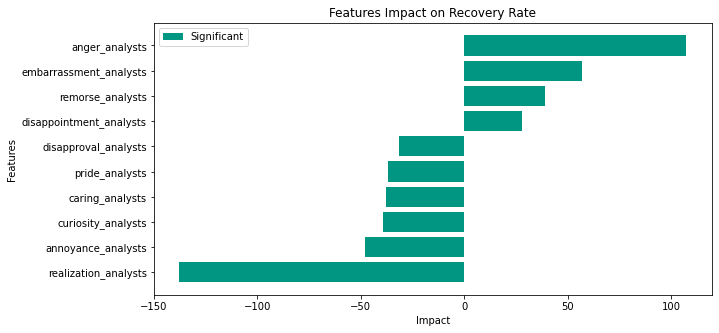

In [154]:
# select significant features
model.significance = model.pvalues[model.pvalues < 0.05].index

# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

# Sort the importance values based on absolute values, not just positive or negative
top_10_importances = importances.abs().sort_values(ascending=False).head(10)

# reduce importances to only the top 10
importances = importances[top_10_importances.index]
importances = importances.sort_values()

# color significant features 0/150/130 and others in grey
colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values, color=colors)
# add legend
plt.legend(['Significant', 'Not Significant'])
plt.xlabel('Impact')
plt.ylabel('Features')
plt.title('Features Impact on Recovery Rate')
plt.show()

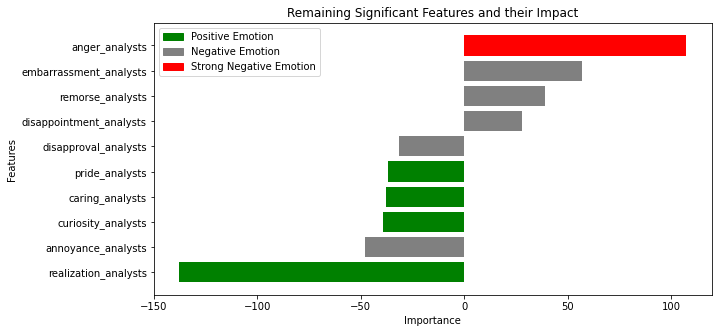

In [155]:
import matplotlib.patches as mpatches

# Filter significant features
significant_features = model.pvalues[model.pvalues < 0.05].index
importances = model.params[significant_features]  # Only significant features
importances = importances[1:]

# Sort importances by their absolute value, and select the top 10
top_12_importances = importances.abs().sort_values(ascending=False).head(10)
importances = importances[top_12_importances.index]
importances = importances.sort_values()  # Sort the values for better visualization

# Define emotion types (assuming the feature names match these emotion labels)
emotion_types = {
    'relief': 'positive',
    'remorse': 'negative',
    'nervousness': 'negative',
    'desire': 'positive',
    'fear': 'strong_negative',
    'excitement': 'positive',
    'confusion': 'negative',
    'pride': 'positive',
    'annoyance': 'negative',
    'gratitude': 'positive',
    'anger': 'strong_negative',
    'optimism': 'positive',
    'sadness': 'negative', 
    'approval': 'positive',
    'caring': 'positive',
    'disappointment': 'negative',
    'curiosity': 'positive',
    'surprise': 'positive',
    'admiration': 'positive',
    'embarrassment': 'negative',
    'realization': 'positive',
    'disapproval': 'negative',
    'joy': 'positive',
    'relief_analysts': 'positive',
    'remorse_analysts': 'negative',
    'nervousness_analysts': 'negative',
    'desire_analysts': 'positive',
    'fear_analysts': 'strong_negative',
    'excitement_analysts': 'positive',
    'confusion_analysts': 'negative',
    'pride_analysts': 'positive',
    'annoyance_analysts': 'negative',
    'gratitude_analysts': 'positive',
    'anger_analysts': 'strong_negative',
    'optimism_analysts': 'positive',
    'sadness_analysts': 'negative',
    'approval_analysts': 'positive',
    'caring_analysts': 'positive',
    'disappointment_analysts': 'negative',
    'curiosity_analysts': 'positive',
    'surprise_analysts': 'positive',
    'admiration_analysts': 'positive',
    'embarrassment_analysts': 'negative',
    'realization_analysts': 'positive',
    'disapproval_analysts': 'negative',
    'joy_analysts': 'positive'
}

# Map colors to each emotion type
color_mapping = {
    'positive': 'green',
    'strong_negative': 'red',
    'negative': 'gray',
}

# Apply the color mapping to the top 12 significant features
colors = []
for feature in importances.index:
    if feature in supporting_features_1 or feature in supporting_features_2:
        colors.append('blue')
    elif feature in presentation_labels or feature in qna_labels:
        colors.append('orange')
    elif feature in emotion_types:
        colors.append(color_mapping[emotion_types[feature]])
    else:
        colors.append('black')  # Default for unknown features

# Create a horizontal bar plot for the top 12 significant features
plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values, color=colors)

# Add labels and title
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Remaining Significant Features and their Impact')

# Create a custom legend
handles = [
    #plt.Rectangle((0, 0), 1, 1, color='blue'),
    #plt.Rectangle((0, 0), 1, 1, color='orange'),
    plt.Rectangle((0, 0), 1, 1, color='green'),
    plt.Rectangle((0, 0), 1, 1, color='gray'),
    plt.Rectangle((0, 0), 1, 1, color='red')
]
labels = [#'Financial Data', 
          #'LLM Labels', 
          'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion']

# Add the legend
plt.legend(handles, labels)

# Show the plot
plt.show()


                               OLS Regression Results                               
Dep. Variable:     transaction_chain_length   R-squared:                       0.014
Model:                                  OLS   Adj. R-squared:                  0.013
Method:                       Least Squares   F-statistic:                     31.40
Date:                      Tue, 22 Oct 2024   Prob (F-statistic):          6.28e-131
Time:                              11:48:25   Log-Likelihood:                -61390.
No. Observations:                     49778   AIC:                         1.228e+05
Df Residuals:                         49755   BIC:                         1.230e+05
Df Model:                                22                                         
Covariance Type:                  nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

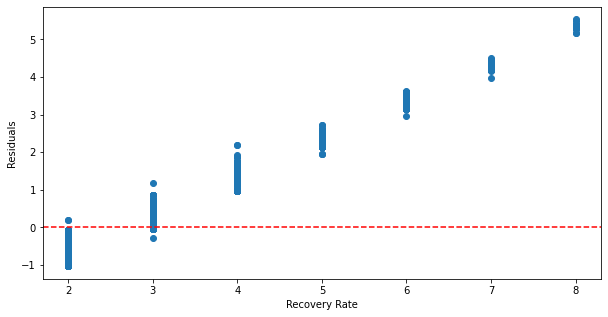

In [134]:
'''Transaction Chain Length Prediction'''
# In-Sample-Regression: Transaction Chain Length
y_train, y_test = final_df['transaction_chain_length'], final_df['transaction_chain_length']
X_train, X_test = final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']), final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [ ]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

In [ ]:
# select significant features
model.significance = model.pvalues[model.pvalues < 0.05].index

# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

# Sort the importance values based on absolute values, not just positive or negative
top_10_importances = importances.abs().sort_values(ascending=False).head(15)

# reduce importances to only the top 10
importances = importances[top_10_importances.index]
importances = importances.sort_values()

# color significant features 0/150/130 and others in grey
colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values, color=colors)
# add legend
plt.legend(['Significant', 'Not Significant'])
plt.xlabel('Impact')
plt.ylabel('Features')
plt.title('Features Impact on Recovery Rate')
plt.show()

In [159]:
'''Primary Dealer Classification'''
'''Is the probability of being a primary dealer related to earnings call features?'''

# percentage of trades per CUSIP that are primary dealer trades
dealer_df['count_primary_dealer'] = dealer_df.groupby('CUSIP')['PrimaryDealer'].transform('sum')
dealer_df['count_total'] = dealer_df.groupby('CUSIP')['PrimaryDealer'].transform('count')
dealer_df['percentage_primary_dealer'] = dealer_df['count_primary_dealer'] / dealer_df['count_total']

# drop the count columns
dealer_df.drop(columns=['count_primary_dealer', 'count_total'], inplace=True)

<AxesSubplot:>

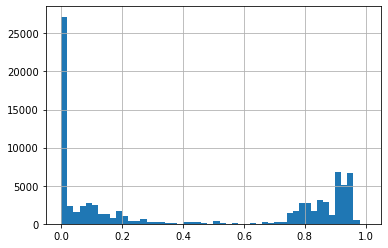

In [160]:
# show distribution of the new feature
dealer_df['percentage_primary_dealer'].hist(bins=50)

In [161]:
# convert percentage_primary_dealer to a binary feature
dealer_df['by_primary_dealer'] = dealer_df['percentage_primary_dealer'].apply(lambda x: 1 if x > 0.5 else 0)

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

logreg = LogisticRegression(class_weight='balanced')
svm = SVC(class_weight='balanced')
forest = RandomForestClassifier(class_weight='balanced')

feature_sets = {'Financial Data 1': supporting_features_1, 
                'Financial Data 1&2': supporting_features_1 + supporting_features_2,
                'Presentation Labels': presentation_labels, 
                'Q&A Labels':qna_labels, 
                'Management Emotions': emotions, 
                'Analyst Emotions': analyst_emotions,
                'LLM Labels': presentation_labels + qna_labels,
                'All Emotions': emotions + analyst_emotions,
                'All combined': presentation_labels + qna_labels + emotions + analyst_emotions
                }

for key in feature_sets:
    # Set features (earnings call features) and target (PrimaryDealer)
    final_df = dealer_df[['by_primary_dealer'] + feature_sets[key]]

    # drop duplicates
    final_df = final_df.drop_duplicates()

    X = final_df.drop(columns='by_primary_dealer')
    y = final_df['by_primary_dealer']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = X, X, y, y

    # Fit logistic regression model
    logreg.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    forest.fit(X_train, y_train)

    # Predict
    y_pred_log = logreg.predict(X_test)
    y_pred_svm = svm.predict(X_test)
    y_pred_forest = forest.predict(X_test)

    # Evaluation metrics for Logistic Regression
    log_accuracy = accuracy_score(y_test, y_pred_log)
    log_roc_auc = roc_auc_score(y_test, y_pred_log)
    log_classification_report = classification_report(y_test, y_pred_log, zero_division=1)

    print(f"Features: {key}")
    print("Logistic Regression Results:")
    print(log_classification_report)
    print(f"ROC AUC Logistic Regression: {log_roc_auc}")
    print(f"Accuracy Logistic Regression: {log_accuracy}")

    # Evaluation for SVM
    svm_accuracy = accuracy_score(y_test, y_pred_svm)
    print(f"Accuracy SVM: {svm_accuracy}")

    # Evaluation for Random Forest
    forest_accuracy = accuracy_score(y_test, y_pred_forest)
    print(f"Accuracy Random Forest: {forest_accuracy}")
    print('---------------------------------')



Features: Financial Data 1
Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       908
           1       1.00      0.00      0.00       145

    accuracy                           0.86      1053
   macro avg       0.93      0.50      0.46      1053
weighted avg       0.88      0.86      0.80      1053

ROC AUC Logistic Regression: 0.5
Accuracy Logistic Regression: 0.862298195631529
Accuracy SVM: 0.3798670465337132
Accuracy Random Forest: 1.0
---------------------------------
Features: Financial Data 1&2
Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       908
           1       1.00      0.00      0.00       145

    accuracy                           0.86      1053
   macro avg       0.93      0.50      0.46      1053
weighted avg       0.88      0.86      0.80      1053

ROC AUC Logistic Regression: 0.5
Accuracy Logistic Regre

In [67]:
# Example logistic regression with probabilities and R²
for key in feature_sets:
    # Select the target and feature set
    final_df = dealer_df[['by_primary_dealer'] + feature_sets[key]]

    # Drop duplicates
    final_df = final_df.drop_duplicates()

    # Define features and target variable
    X = final_df.drop(columns='by_primary_dealer')
    y = final_df['by_primary_dealer']

    # Split into training and test sets
    X_train, X_test, y_train, y_test = X, X, y, y

    # Fit logistic regression model
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train, y_train)

    # Predict probabilities on the test set
    y_pred_prob = logreg.predict_proba(X_test)[:, 1]  # Predict the probability of being a primary dealer

    # Calculate R² score using predicted probabilities
    r2 = r2_score(y_test, y_pred_prob)

    # Get coefficients (feature importance)
    coefficients = logreg.coef_[0]

    # Create DataFrame for feature importance
    feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})

    # Sort by absolute coefficient values to get the most important features
    top_10_features = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index).head(10)

    # Print the results
    print(f"Features: {key}")
    print(f"R² Score (based on predicted probabilities): {r2}")
    print("Top 10 Important Features:")
    print(top_10_features)
    print('---------------------------------')


Features: Financial Data 1
R² Score (based on predicted probabilities): -0.19323919808967482
Top 10 Important Features:
                                     Feature   Coefficient
12                           Offering amount -7.163162e-06
7                           Time to maturity -1.112639e-07
8                               Equity value -8.830467e-08
13                                    Volume -1.365424e-09
0                 CBOE DJIA Volatility Index -1.006609e-09
3         30 year conventional mortgage rate -1.960383e-10
2   Manufacturers inventories to sales ratio -5.066839e-11
9                           CDS availability -2.963984e-11
11                      ActIndustryDistress2 -2.782439e-11
10                      ActIndustryDistress1 -2.685333e-11
---------------------------------
Features: Financial Data 1&2
R² Score (based on predicted probabilities): -0.19323919807685463
Top 10 Important Features:
                                     Feature   Coefficient
12              

In [164]:
from statsmodels.discrete.discrete_model import Probit

# Example logistic regression with probabilities and R²
for key in feature_sets:
    # Select the target and feature set
    final_df = dealer_df[['by_primary_dealer'] + feature_sets[key]]

    # Drop duplicates
    final_df = final_df.drop_duplicates()

    # Define features and target variable
    X = final_df.drop(columns='by_primary_dealer')
    y = final_df['by_primary_dealer']

    # Split into training and test sets
    X_train, X_test, y_train, y_test = X, X, y, y

    # Fit logistic regression model
    # Fit the probit model
    probit_model = Probit(y, X)
    probit_results = probit_model.fit()
    print(probit_results.summary())


         Current function value: 0.327762
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:      by_primary_dealer   No. Observations:                 1053
Model:                         Probit   Df Residuals:                     1031
Method:                           MLE   Df Model:                           21
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.1822
Time:                        16:31:06   Log-Likelihood:                -345.13
converged:                      False   LL-Null:                       -422.01
Covariance Type:            nonrobust   LLR p-value:                 3.387e-22
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
CBOE DJIA Volatility Index               -1.564e-05      0.008     -0.002      0.998

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          Probit Regression Results                           
Dep. Variable:      by_primary_dealer   No. Observations:                 1053
Model:                         Probit   Df Residuals:                     1027
Method:                           MLE   Df Model:                           25
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.1845
Time:                        16:31:06   Log-Likelihood:                -344.13
converged:                      False   LL-Null:                       -422.01
Covariance Type:            nonrobust   LLR p-value:                 7.268e-21
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
CBOE DJIA Volatility Index                  -0.0023      0.009     -0.250      0.803      -0.020       0.016
NASDAQ 100 Index return                  

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          Probit Regression Results                           
Dep. Variable:      by_primary_dealer   No. Observations:                  207
Model:                         Probit   Df Residuals:                      185
Method:                           MLE   Df Model:                           21
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                 0.08584
Time:                        16:31:06   Log-Likelihood:                -53.729
converged:                       True   LL-Null:                       -58.774
Covariance Type:            nonrobust   LLR p-value:                    0.9777
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
negative_sentiment                      2.4209      1.684      1.437      0.151      -0.880       5.722
positive_sentiment                      0.1096      2.13

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          Probit Regression Results                           
Dep. Variable:      by_primary_dealer   No. Observations:                  207
Model:                         Probit   Df Residuals:                      163
Method:                           MLE   Df Model:                           43
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                  0.4870
Time:                        16:31:07   Log-Likelihood:                -30.153
converged:                      False   LL-Null:                       -58.774
Covariance Type:            nonrobust   LLR p-value:                   0.07173
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
admiration                  0.4915      1.802      0.273      0.785      -3.039       4.022
anger                      -0.5941      2.318     -0.256      0.798      -5.138       3.950


/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
